In [1]:
import open3d as o3d
import time
import skvideo.io 
import skimage.io
import skimage.transform
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import os, subprocess

from pathlib import Path

from lightglue import LightGlue, SuperPoint, DISK
from lightglue.utils import load_image, rbd
from lightglue import viz2d
import torch

torch.set_grad_enabled(False)

# Make Scikit-Video happy
np.float = np.float64
np.int = np.int_

# From
# https://medium.com/@nearlydaniel/assertion-of-arbitrary-array-shapes-in-python-3c96f6b7ccb4
from collections import defaultdict
def assert_shape(x, shape:list):
    """ ex: assert_shape(conv_input_array, [8, 3, None, None]) """
    assert len(x.shape) == len(shape), (x.shape, shape)
    for _a, _b in zip(x.shape, shape):
        if isinstance(_b, int):
            assert _a == _b, (x.shape, shape)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


/home/dylan/Documents/Dev/School/CSC487-Project/Xtractofuse/.venv/lib/python3.10/site-packages/kornia/feature/lightglue.py:44: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)
/home/dylan/Documents/Dev/School/CSC487-Project/Xtractofuse/LightGlue/lightglue/lightglue.py:24: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)


In [2]:
DATA_PATH = Path("data/desks")

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # 'mps', 'cpu'

extractor = SuperPoint(max_num_keypoints=2048).eval().to(device)  # load the extractor
matcher = LightGlue(features="superpoint").eval().to(device)

In [4]:
def get_matches(image0: np.ndarray, image1: np.ndarray):

    width = image0.shape[0]
    height = image0.shape[1]

    assert_shape(image1, (width, height, 3))

    image0 = torch.from_numpy(image0.transpose(2, 0, 1))
    image1 = torch.from_numpy(image1.transpose(2, 0, 1))

    feats0 = extractor.extract(image0.to(device))
    feats1 = extractor.extract(image1.to(device))
    matches01 = matcher({"image0": feats0, "image1": feats1})
    feats0, feats1, matches01 = [
        rbd(x) for x in [feats0, feats1, matches01]
    ]  # remove batch dimension

    kpts0, kpts1, matches = feats0["keypoints"], feats1["keypoints"], matches01["matches"]
    m_kpts0, m_kpts1 = kpts0[matches[..., 0]], kpts1[matches[..., 1]]

    return m_kpts0, m_kpts1

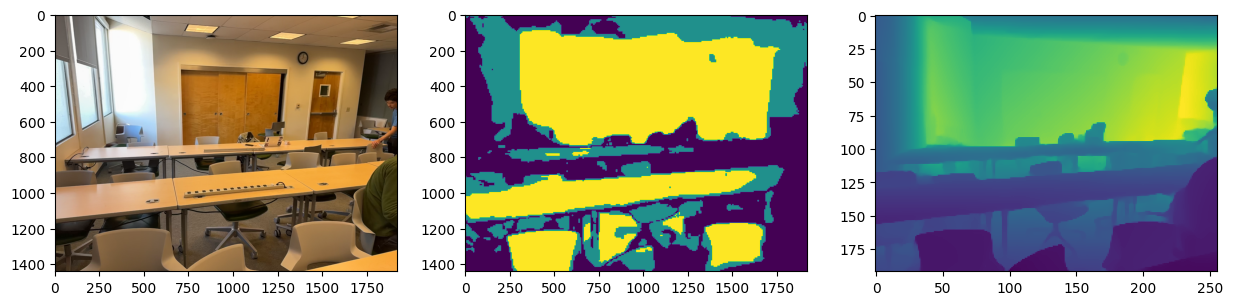

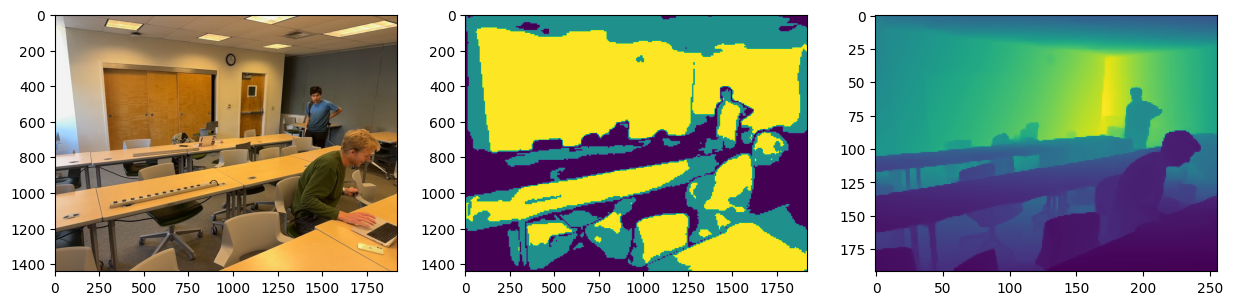

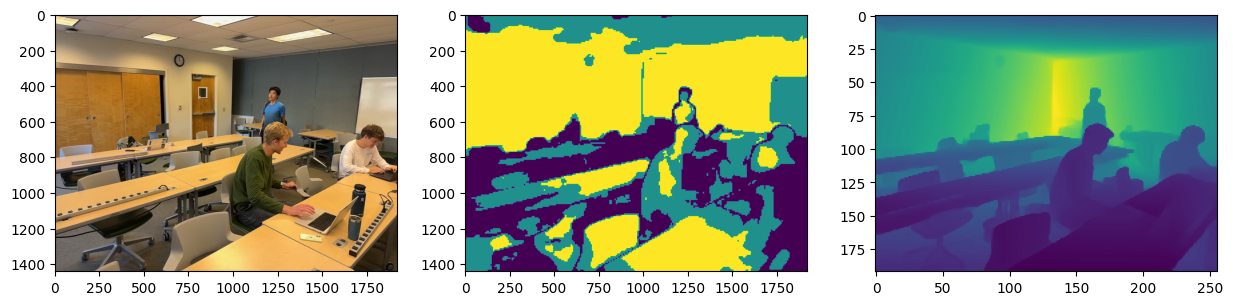

In [5]:
rgb_images = np.array(list(skvideo.io.vreader(str(DATA_PATH.joinpath("rgb.mp4")))))
rgb_images = (rgb_images.astype('float32') / 255.0)

confidence_images = [skimage.io.imread(path) for path in sorted(list(DATA_PATH.glob("confidence/*.png")))]
confidence_images = np.array([skimage.transform.resize(img, rgb_images[0].shape[0:2], order=0) for img in confidence_images])

depth_image_paths = sorted(list(DATA_PATH.glob("depth/*.png")))
depth_images = [skimage.io.imread(path) for path in depth_image_paths]

# Weird case where we skip first frame
if len(rgb_images) == len(confidence_images) - 1 and len(rgb_images) == len(depth_images) - 1:
    confidence_images = confidence_images[1:]
    depth_images = depth_images[1:]

assert len(rgb_images) == len(confidence_images) == len(depth_images), (len(rgb_images), len(confidence_images), len(depth_images))


# Show images in horizontal row

for i in range(0, len(rgb_images[0:5])):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(rgb_images[i])
    axes[1].imshow(confidence_images[i])
    axes[2].imshow(depth_images[i]);

intrinsics = np.genfromtxt(DATA_PATH.joinpath("camera_matrix.csv"), delimiter=',')


In [6]:
def points_2d_to_3d(points_homogenous_2d: np.ndarray, depths: np.ndarray, calibration_matrix: np.ndarray) -> np.ndarray:

    assert_shape(points_homogenous_2d, (None, 3))

    point_num = len(points_homogenous_2d)

    assert_shape(depths, (point_num, 1))
    assert_shape(calibration_matrix, (3,3))

    # Ray from Point in Image:
    # Ideas from https://www.cs.cmu.edu/~16385/s17/Slides/11.1_Camera_matrix.pdf
    # And https://stackoverflow.com/questions/68249598/how-to-calculate-the-ray-of-a-camera-with-the-help-of-the-camera-matrix

    camera_matrix_inv = np.linalg.inv(calibration_matrix)

    directions = np.matmul(camera_matrix_inv, points_homogenous_2d.T).T
    directions = directions / np.linalg.norm(directions)
    point_cloud = directions * depths # Add Depth info!


    assert_shape(point_cloud, (None, 3))

    return point_cloud[:, 0:3]

def image_to_point_cloud(calibration_matrix: np.array, rgb_image: np.array, depth_map: np.array) -> np.array:
    assert_shape(calibration_matrix, (3,3))

    assert_shape(rgb_image, (None, None, 3))
    height = rgb_image.shape[0]
    width = rgb_image.shape[1]

    assert_shape(depth_map, (None, None))


    xv, yv = np.meshgrid(np.arange(width), np.arange(height))
    all_pixels = np.stack([xv.ravel(), yv.ravel(), np.ones_like(xv).ravel()], axis=1)

    # Upscale depth to the same as our RGB image
    upscaled_depth_image = skimage.transform.resize(depth_map, rgb_image.shape[0:2], order=0)

    point_cloud = points_2d_to_3d(all_pixels, upscaled_depth_image.reshape(-1, 1), calibration_matrix)

    assert_shape(point_cloud, (None, 3))

    return point_cloud

In [7]:
def compute_euclidean_transform_ransac(image0, point_cloud0, image1, point_cloud1, matching_threshold=0.3, iterations=100, confidence_image0=None, confidence_image1=None)-> skimage.transform.EuclideanTransform:
    
    assert_shape(image0, (None, None, 3))
    
    image0_height = image0.shape[0]
    image0_width = image0.shape[1]
    assert_shape(point_cloud0, (image0_height * image0_width, 3))


    assert_shape(image1, (None, None, 3))

    image1_height = image1.shape[0]
    image1_width = image1.shape[1]

    assert_shape(point_cloud1, (image1_height * image1_width, 3))

    if confidence_image0 is None:
        assert confidence_image1 is None
    else:
        assert_shape(confidence_image0, (image0_height, image0_width))
        assert_shape(confidence_image1, (image0_height, image0_width))



    # Shape (None, 2), (None, 2)
    matched_keypoints0, matched_keypoints1 = get_matches(image0, image1)

    # Round to nearest pixel
    matched_keypoints0 = np.round(matched_keypoints0.numpy()).astype(int)
    matched_keypoints1 = np.round(matched_keypoints1.numpy()).astype(int)

    # Turn (x, y) from image coordinates into index into point cloud
    point_cloud0_indices = matched_keypoints0[:, 0] + matched_keypoints0[:, 1] * image0_width
    point_cloud1_indices = matched_keypoints1[:, 0] + matched_keypoints1[:, 1] * image1_width

    print(point_cloud0_indices[0:10])

    # Filter only the high confidence matches
    if confidence_image0 is not None:
        image0_confidence_mask = confidence_image0.flatten() >= 2
        image1_confidence_mask = confidence_image1.flatten() >= 2

        matches_before = len(point_cloud0_indices)

        good_keypoint_matches_mask = (image0_confidence_mask[point_cloud0_indices]) & (image1_confidence_mask[point_cloud1_indices])
        point_cloud0_indices = point_cloud0_indices[good_keypoint_matches_mask]
        point_cloud1_indices = point_cloud1_indices[good_keypoint_matches_mask]

        print(f"Matches before: {matches_before}, Matches after filtering on confidence >= 2: {len(point_cloud0_indices)}")

    # Get the 3D points for the matched keypoints
    matched_point_cloud0 = point_cloud0[point_cloud0_indices]
    matched_point_cloud1 = point_cloud1[point_cloud1_indices]


    best_model = None
    best_inlier_count = 0

    for _ in range(iterations):

        # Get 3 random indices
        random_indices = np.random.choice(len(matched_point_cloud0), 3)

        model = skimage.transform.EuclideanTransform()
        model.estimate(matched_point_cloud0[random_indices], matched_point_cloud1[random_indices])

        transformed_points = model(matched_point_cloud0)

        # Get inliers under threshold
        error = np.sqrt(np.sum((transformed_points - matched_point_cloud1)**2, axis=1))

        inlier_count = np.count_nonzero(error < matching_threshold)

        if inlier_count > best_inlier_count:
            best_inlier_count = inlier_count
            best_model = model
    
    return best_model


In [8]:
def add_point_cloud_to_viz(point_cloud, rgb, vis):
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(point_cloud)
    pcd.colors = o3d.utility.Vector3dVector(rgb)

    vis.add_geometry(pcd)

In [9]:
from itertools import tee

def pairwise(iterable):
    "s -> (s0,s1), (s1,s2), (s2, s3), ..."
    a, b = tee(iterable)
    next(b, None)
    return zip(a, b)

In [ ]:


transform_0_to_first = None



# Start out with points from first frame
point_cloud_all = image_to_point_cloud(intrinsics, rgb_images[0], depth_images[0])[confidence_images[0].flatten() >= 2]
rgb_data_all = rgb_images[0][confidence_images[0] >= 2]

print(f"point cloud 0: {point_cloud_all.shape}, rgb0: {rgb_data_all.shape}")

for rgb1, depth1, confidence1 in zip(rgb_images[1:], depth_images[1:], confidence_images[1:]):

    print("Processing frame")

    point_cloud1 = image_to_point_cloud(intrinsics, rgb1, depth1)

    model_1_to_0 = compute_euclidean_transform_ransac(rgb0, point_cloud0, 
                                            rgb1, point_cloud1, 
                                            matching_threshold=0.1, iterations=1000,
                                            confidence_image0=confidence0,
                                            confidence_image1=confidence1)

    if transform_0_to_first is None:
        transform_1_to_first = model_1_to_0
    else:
        transform_1_to_first = transform_0_to_first + model_1_to_0

    point_cloud1 = model_1_to_0(point_cloud1)


    # Filter based on confidence
    filtered_point_cloud1 = point_cloud1[confidence1.flatten() >= 2]
    filtered_video_data1 = rgb1[confidence1 >= 2]

    print(f"point cloud 1: {filtered_point_cloud1.shape}, rgb1: {filtered_video_data1.shape}")
    point_cloud_all = np.concatenate((point_cloud_all, filtered_point_cloud1))
    rgb_data_all = np.concatenate((rgb_data_all, filtered_video_data1))

    # For next iteration
    transform_0_to_first = transform_1_to_first
    
    point_cloud0 = point_cloud1
    confidence0 = confidence1
    rgb0 = rgb1

# create visualizer and window.
vis = o3d.visualization.Visualizer()
vis.create_window(height=480, width=640)

assert_shape(point_cloud_all, (None, 3))
assert_shape(rgb_data_all, (None, 3))

add_point_cloud_to_viz(point_cloud_all, rgb_data_all, vis)

# run non-blocking visualization. 
# To exit, press 'q' or click the 'x' of the window.
keep_running = True
while keep_running:
    keep_running = vis.poll_events()
    vis.update_renderer()

vis.destroy_window()

point cloud 0: (1186688, 3), rgb0: (1186688, 3)
Processing frame
[1539334  501818 1624414 1159881 1427387 1275495 1311891 2147312 2389949
 1559684]
Matches before: 1056, Matches after filtering on confidence >= 2: 347
point cloud 1: (1350900, 3), rgb1: (1350900, 3)
Processing frame
[2427548 2439042 1412297 1316327 1353546 1287769 1205573 1250813   58812
 1501879]
Matches before: 1056, Matches after filtering on confidence >= 2: 347
point cloud 1: (1251853, 3), rgb1: (1251853, 3)


In [11]:

import os
import numpy as np
from PIL import Image
import argparse
np.float, np.int = np.float64, np.int_
import open3d as o3d
from plyfile import PlyData, PlyElement
import subprocess

DEPTH_WIDTH = 256
DEPTH_HEIGHT = 192
MAX_DEPTH = 20.0
EVERY = 0.0

def quaternion_to_rotation_matrix(quaternion):
    qx, qy, qz, qw = quaternion
    return np.array([
        [1 - 2 * (qy**2 + qz**2), 2 * (qx * qy - qz * qw), 2 * (qx * qz + qy * qw)],
        [2 * (qx * qy + qz * qw), 1 - 2 * (qx**2 + qz**2), 2 * (qy * qz - qx * qw)],
        [2 * (qx * qz - qy * qw), 2 * (qy * qz + qx * qw), 1 - 2 * (qx**2 + qy**2)]
    ])

def get_intrinsics(intrinsics):
    fx = intrinsics[0, 0]
    fy = intrinsics[1, 1]
    cx = intrinsics[0, 2]
    cy = intrinsics[1, 2]
    return np.array([[fx * DEPTH_WIDTH / 1920, 0, cx * DEPTH_WIDTH / 1920],
                     [0, fy * DEPTH_HEIGHT / 1440, cy * DEPTH_HEIGHT / 1440],
                     [0, 0, 1]])

def create_point_cloud(rgbd, intrinsics, T_CW):
    rgb, depth = rgbd
    fx, fy = intrinsics[0, 0], intrinsics[1, 1]
    cx, cy = intrinsics[0, 2], intrinsics[1, 2]

    points, colors = [], []
    for v in range(depth.shape[0]):
        for u in range(depth.shape[1]):
            z = depth[v, u]
            if z > 0 and z < MAX_DEPTH:
                x = (u - cx) * z / fx
                y = (v - cy) * z / fy
                point_world = T_CW[:3, :3] @ np.array([x, y, z]) + T_CW[:3, 3]
                points.append(point_world)
                colors.append(rgb[v, u] / 255.0)
    return np.array(points), np.array(colors)

def accumulate_point_cloud(pc, rgbd, intrinsics, T_CW):
    points, colors = create_point_cloud(rgbd, intrinsics, T_CW)
    pc[0].extend(points)
    pc[1].extend(colors)

def save_point_cloud_to_ply(filename, points, colors):
    vertices = [(points[i, 0], points[i, 1], points[i, 2],
             int(colors[i, 0] * 255), int(colors[i, 1] * 255), int(colors[i, 2] * 255))
            for i in range(points.shape[0])]
    ply_data = PlyElement.describe(
        np.array(vertices, dtype=[('x', 'f4'), ('y', 'f4'), ('z', 'f4'),
                                ('red', 'u1'), ('green', 'u1'), ('blue', 'u1')]),
        'vertex')
    PlyData([ply_data]).write(filename)

def visualize_point_cloud(points, colors):
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)
    pcd.colors = o3d.utility.Vector3dVector(colors)
    o3d.visualization.draw_geometries([pcd])


odometry = np.loadtxt(os.path.join(DATA_PATH, 'odometry.csv'), delimiter=',', skiprows=1)
poses = []

for line in odometry:
    position, quaternion = line[2:5], line[5:]
    T_WC = np.eye(4)
    T_WC[:3, :3] = quaternion_to_rotation_matrix(quaternion)
    T_WC[:3, 3] = position
    poses.append(T_WC)

intrinsics = np.loadtxt(os.path.join(DATA_PATH, 'camera_matrix.csv'), delimiter=',')
intrinsics = get_intrinsics(intrinsics)
pc = ([], [])


for i, T_WC in enumerate(poses):
    if i % EVERY != 0:
        continue
    print(f"Point cloud {i}", end="\r")
    T_CW = np.linalg.inv(T_WC)
    confidence = np.array(Image.open(os.path.join(args.path, 'confidence', f'{i:06}.png')))
    depth_path = data['depth_frames'][i]
    depth_m = np.array(Image.open(depth_path)).astype(np.float32) / 1000.0
    depth_m[confidence < args.confidence] = 0.0
    
    rgb_frame_path = os.path.join(frame_dir, f'{i:06}.png')
    rgb_frame = np.array(Image.open(rgb_frame_path))
    rgbd = (np.array(Image.fromarray(rgb_frame).resize((DEPTH_WIDTH, DEPTH_HEIGHT))), depth_m)
    
    accumulate_point_cloud(pc, rgbd, intrinsics, T_WC)

points, colors = np.array(pc[0]), np.array(pc[1])




def main():
    parser = argparse.ArgumentParser()
    parser.add_argument('path', type=str)
    parser.add_argument('--every', type=int, default=1)
    parser.add_argument('--confidence', type=int, default=1)
    args = parser.parse_args()

    
    

    depth_dir = os.path.join(args.path, 'depth')
    depth_frames = [os.path.join(depth_dir, p) for p in sorted(os.listdir(depth_dir))]

    process_point_clouds(args, {'poses': poses, 'intrinsics': intrinsics, 'depth_frames': depth_frames})
 


ZeroDivisionError: float modulo